# 1. Análisis exploratorio de sismos

**Objetivo:** Exploración del dataset

Esta base de de datos es una colección de más de 23,000 sismos en USA. Contiene datos desde 1638 a 1985. La base de datos incluye información correspondiente a las coordenadas del epicentro, magnitudes, profundidad focal, nombres y coordenadas de ciudades reportadas, intensidades reportadas y la distancia de la ciudad al epicentro.


https://www.kaggle.com/srijya/us-earthquake-intensity-database

**Información de las características**
* 0 Year Mo Da Hr Mn Sec
* 1 UTC Conv
* 2 U/G Unpublished or grouped intensity
* 3 EQ Lat 
* 4 EQ Long
* 5 Magnitude
* 6 Depth (km)
* 7 Epi Dis Distancia epicentral
* 8 City Lat
* 9 City Long
* 10 MMI
* 11 State Code
* 12 City Name
* 13 Data Source

**Número de instancias:** 157015

**Número de atributos:** 20



# 2. Acceso a Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 3. Importando librerías

In [33]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.io as pio
from sklearn.neighbors import LocalOutlierFactor

# 4. Lectura del archivo de datos

In [3]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/2. Preparación de los datos'
name = 'eqint_tsqp.xlsx'

In [5]:
sis_path = os.path.join(path,name)
sismosdf = pd.read_excel(sis_path)
sismosdf.head()

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LOCAL_TO_UTC,UNPUB_OR_GROUPED_INT,LATITUDE,LONGITUDE,MAGNITUDE,EQ_DEPTH,EPIDIST,CITY_LAT,CITY_LON,MMI,STATE,CITY,SOURCE,COUNTRY
0,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,0.0,34.50,-119.00,7.0,CA,LOCKWOOD VALLEY,H,USA
1,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,258.0,33.02,-116.84,6.0,CA,SAN DIEGO,H,USA
2,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,159.0,35.35,-120.41,6.0,CA,SAN LUIS OBISPO,H,USA
3,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,NaN,NaN,NaN,6.0,CA,COLORADO RIVER,H,USA
4,1860,11.0,12.0,NaN,NaN,NaN,8.0,NaN,41.0,-124.0,NaN,NaN,32.0,40.76,-124.22,8.0,CA,HUMBOLDT BAY,H,USA


In [6]:
sismosdf.shape

(157015, 20)

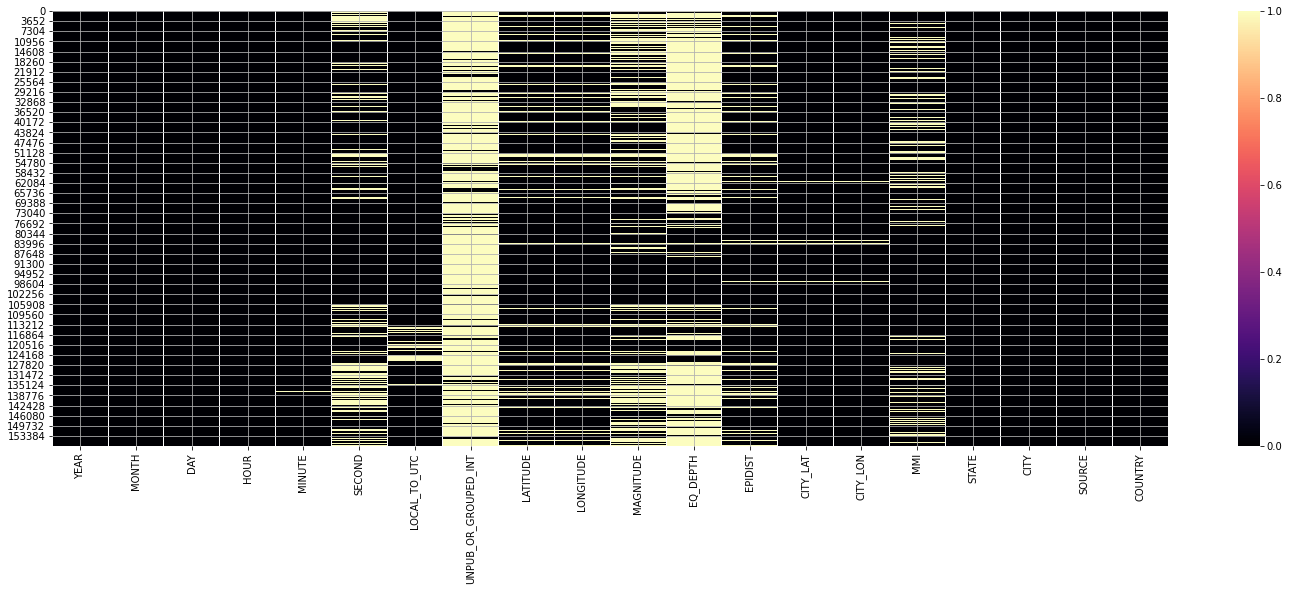

In [7]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(sismosdf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

# 5. Limpieza de datos

Eliminación de columnas repletas de Nans

In [8]:
sismosdf.drop(['UNPUB_OR_GROUPED_INT','LATITUDE','LONGITUDE','EQ_DEPTH', 'LOCAL_TO_UTC'], axis=1, inplace=True)

Rellenando valores valores faltantes

In [9]:
sismosdf['SECOND'].fillna(0, inplace=True)
sismosdf['MINUTE'].fillna(sismosdf['MINUTE'].mode(), inplace=True)
sismosdf['HOUR'].fillna(sismosdf['HOUR'].mode(), inplace=True)
sismosdf['EPIDIST'].fillna(sismosdf['EPIDIST'].mean(), inplace=True)

Nos vamos a quedar con las instancias diferentes de Nans

In [10]:
sismosdf = sismosdf[sismosdf.MMI.notnull()]
sismosdf = sismosdf[sismosdf.YEAR.notnull()]
sismosdf = sismosdf[sismosdf.MONTH.notnull()]
sismosdf = sismosdf[sismosdf.DAY.notnull()]
sismosdf = sismosdf[sismosdf.CITY_LAT.notnull()]
sismosdf = sismosdf[sismosdf.CITY_LON.notnull()]
sismosdf = sismosdf[sismosdf.MAGNITUDE.notnull()]

Visualicemos de nuevo nuestro dataframe

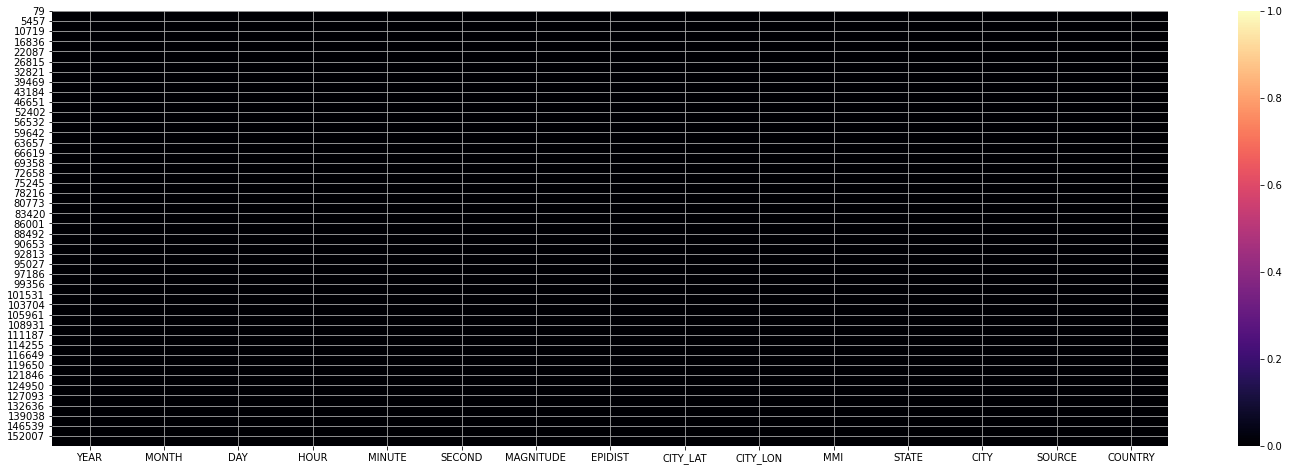

In [11]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(sismosdf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

Ahora veamos cuantos datos perdimos :(

In [12]:
sismosdf.shape

(89617, 15)

# 6. Exploración de los datos

Ahora visualicemos la columna MMI (que corresponde a intensidad)

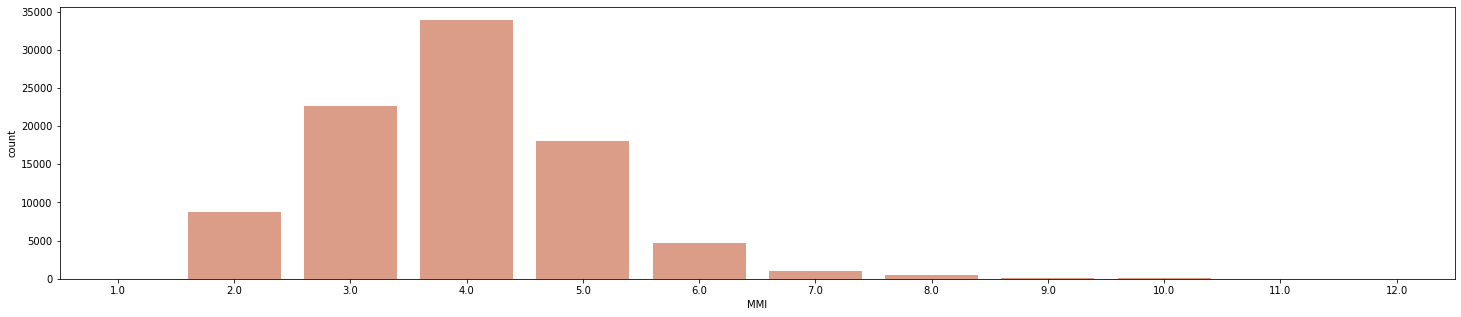

In [13]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['MMI'], color='darksalmon')
plt.show()

Con base en los resultados observados...

¿Cuál es la Intensidad más frecuente?

¿Qué pasa con los sismos de mayor intensidad?

Ahora visualicemos la columna SOURCE (que indica el tipo de fuente) como pie chart... ¿Qué problema tiene?

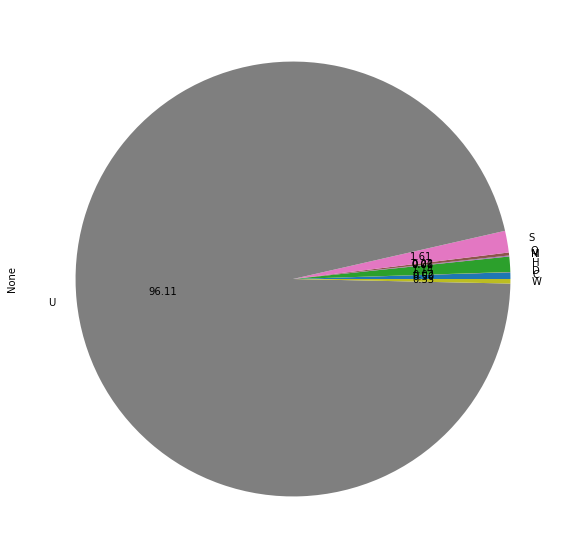

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
sismosdf.groupby('SOURCE').size().plot(kind='pie', autopct='%.2f')

Es mejor cambiar la visualización a barras

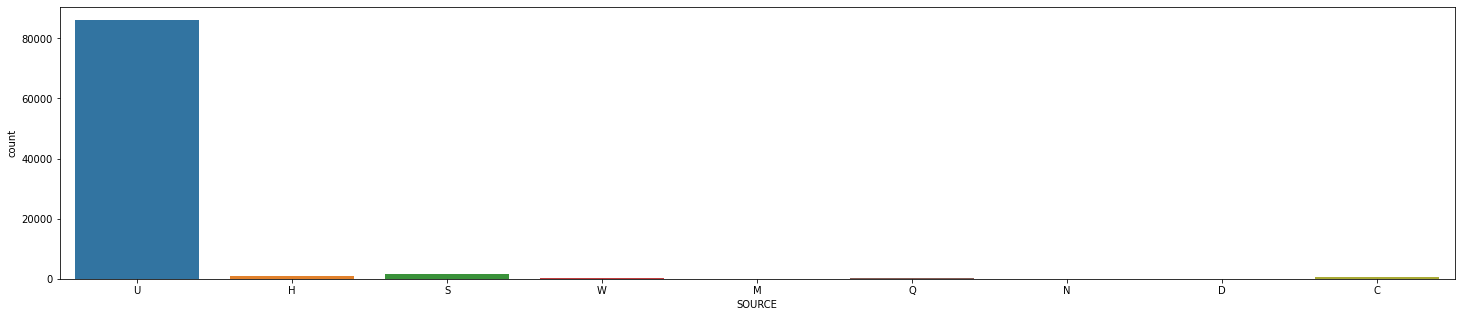

In [15]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['SOURCE'])
plt.show()

Las visualizaciones nos ayudarán a resolve ***preguntas de negocio***

¿Cuál es la magnitud (MAGNITUDE) más frecuente? 

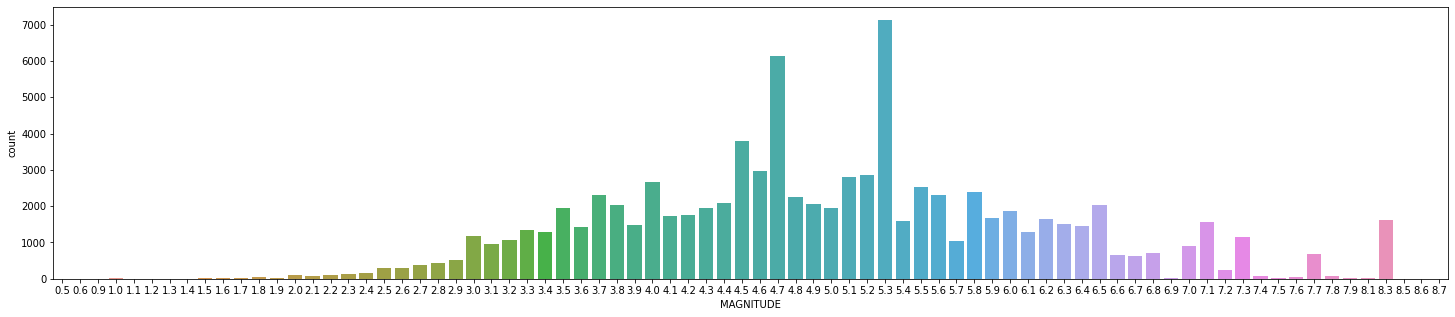

In [16]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['MAGNITUDE'])
plt.show()

¿Cuál es el estado (STATE) con menos sismos históricos?

¿Cuál es el que tiene más?


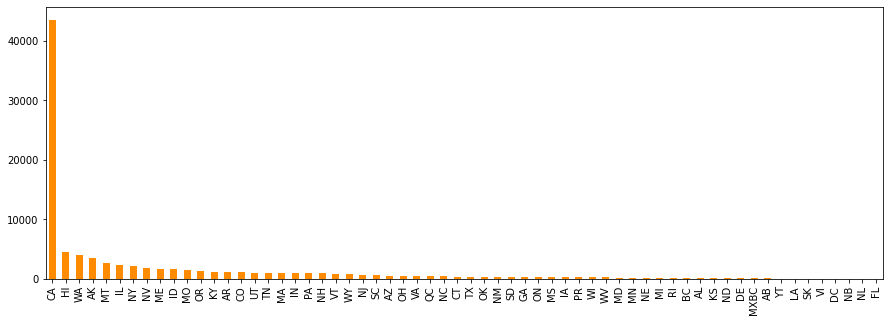

In [17]:
sismosdf['STATE'].value_counts().plot(kind='bar', figsize=(15,5), grid=False, color='darkorange' )

¿En que año (YEAR) se registraron más sismos?

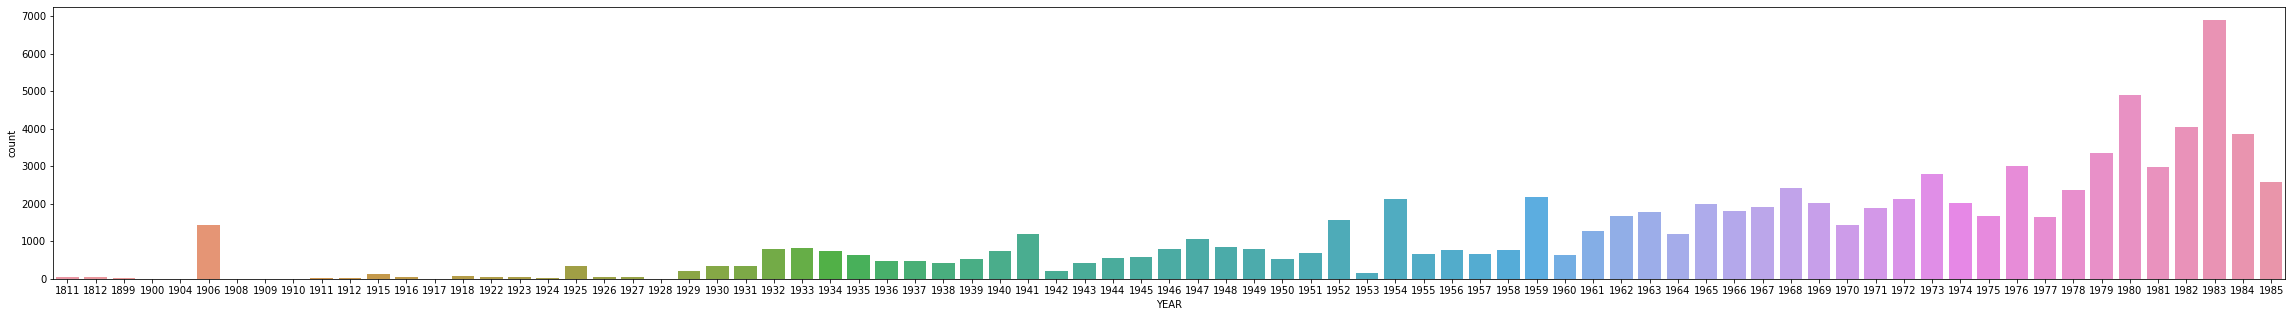

In [18]:
fig, ax = plt.subplots(figsize=(40,5))
sns.countplot(ax=ax, x=sismosdf['YEAR'])
plt.show()

¿ A qué hora (HOUR) es más frecuente que tiemble? 

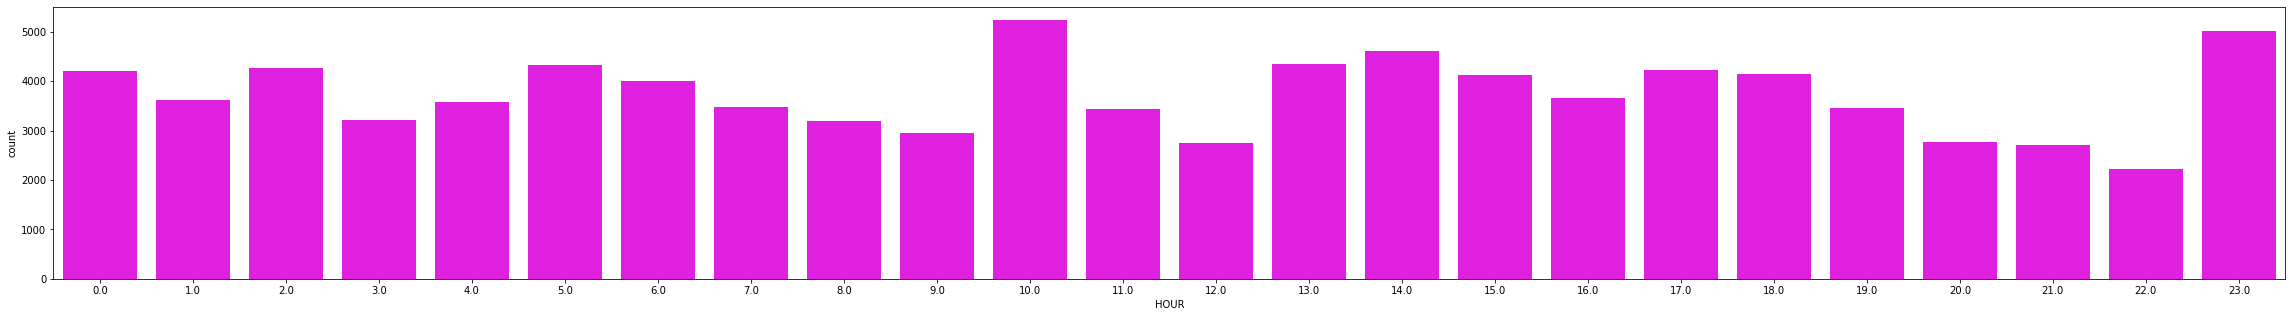

In [24]:
fig, ax = plt.subplots(figsize=(40,5))
sns.countplot(ax=ax, x=sismosdf['HOUR'], color='magenta')
plt.show()

¿Cuáles son los estados que tiene mayor intensidad de sismos?

¿Cómo se ve la distribución de sismos históricos en un mapa?


Usemos las columnas de latitud (CITY_LAT) y longitud (CITY_LON) para visualizar en mapa las intensidades (MMI) de los sismos históricos

In [20]:
fig = go.Figure(data=go.Scattergeo(
        lon = sismosdf['CITY_LON'],
        lat = sismosdf['CITY_LAT'],
        text = sismosdf['MMI'],
        marker = dict(
        color = sismosdf['MMI'],
        colorscale = 'Rainbow',
        reversescale = True,
        opacity = 0.7,
        size = 5,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 1
        )
    )
        ))
fig.update_traces(marker=dict(size=15),
                  selector=dict(mode='markers'))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=25),
    title = 'Intensidad de sismos regional',
    geo_scope='usa',
    )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Ahora respondamos preguntas por año...

1.   ¿Dónde fue ocurrió sismo con mayor intensidad en el año de 1907?

2.   ¿En cuáles estados ocurrieron los sismos de menor intensidad en el año 1929?

3. ¿De qué intensidad promedio fueron los sismos en Atlanta en 1968?

4. ¿Cuál fue la magnitud del sismo de Intensidad 10 de 1971?

En este caso, la mejor estrategia es crear un dashoboard interactivo para poder visualizar por año cada una de las preguntas que debemos resolver...

Empecemos haciendo que el índice del dataframe sea la fecha 

In [ ]:
sismosdf = sismosdf.set_index(['YEAR', 'MONTH'])

In [22]:
sismosdf.head()

DAY  HOUR  MINUTE  ...                      CITY  SOURCE  COUNTRY
YEAR MONTH                      ...                                           
1948 12.0   28.0  12.0    53.0  ...            BORREGO VALLEY       U      USA
     12.0   28.0  12.0    53.0  ...                 SAN DIEGO       U      USA
     12.0   28.0  12.0    53.0  ...                   LA MESA       U      USA
     12.0   28.0  12.0    53.0  ...  OAK GROVE RANGER STATION       U      USA
     12.0   29.0  12.0    53.0  ...                      RENO       U      USA

[5 rows x 13 columns]

Ahora hagamos una lista de estas fechas

In [26]:
index_list = sismosdf.index.levels[0].tolist()

Ahora crearemos frames por año de mapas (donde mostremos la intensidad MMI en el punto geográfico de sus epicentro (CITY_LAT, CITY_LON))

In [27]:
frames=[{'name': 'frame_{}'.format(i),
        # ESTO ES LO QUE DESPLEGAREMOS EN EL MAPA
        'data': [{
            'type': 'scattermapbox',
            'lat': sismosdf.xs(i)['CITY_LAT'],
            'lon': sismosdf.xs(i)['CITY_LON'],
            'marker': go.scattermapbox.Marker(
                size=(sismosdf.xs(i)['MMI']-sismosdf.xs(i)['MMI'].mean()+3.5)**2 +sismosdf.xs(i)['MMI'],
                color=sismosdf.xs(i)['MMI'],
                showscale=True,
                colorscale='Jet',
                colorbar={'title': 'Intensidad', 'titleside': 'top', 'thickness': 4, 'ticksuffix': ' MMI'}
                ),
        # ESTO ES LO QUE SE DESPLEGARÁ EN EL MAPA POR SISMO
        'customdata': np.stack((
            sismosdf.xs(i)['MMI'],
            sismosdf.xs(i)['MAGNITUDE'],
            pd.Series(sismosdf.xs(i).index)),
                axis=-1
                ),
        'hovertemplate': "<extra></extra><em> Intensidad  %{customdata[0]}<br>Magnitud  %{customdata[1]}",
        }],
    } for i in index_list]

Ahora vamos a crear la barra deslizante para tener control sobre los años

In [28]:
sliders = [{
            'transition':{'duration': 0},
            'x':0.08,
            'len':0.88,
            'currentvalue':{'font':{'size':15}, 'prefix':'Año ', 'visible':True, 'xanchor':'center'},
            'steps':[
                {
                    'label':i,
                    'method':'animate',
                    'args':[
                        ['frame_{}'.format(i)],
                        {'mode':'immediate', 'frame':{'duration':1000, 'redraw': True}, 'transition':{'duration':1000, }}
                      ],
                } for i in index_list]
        }]

Crearemos una variable con los datos del primer cuadro

In [29]:
data = frames[0]['data']
data

Ahora añadimos los sliders que creamos a un layout


In [31]:
layout = go.Layout(
    sliders=sliders,
    margin=dict(l=0, r=0, b=0, t=25),
    title = 'Intensidad de sismos por año',
    mapbox={
        'accesstoken':'pk.eyJ1IjoiY2xhdWNvdCIsImEiOiJja2h4MTIxd2UwMzNzMnlvNzVycXN2dW14In0.J_KSzOY3YGDzozRdHvMJgQ',
        'center':{"lat": sismosdf['CITY_LAT'].mean(), "lon": sismosdf['CITY_LON'].mean()+10},
        'zoom':3,
        'style':'light',
    }
)

Por último sólo queda graficar nuestro dashboard interactivo pero no sin antes recordar las preguntas de negocio a las que debemos dar solución...



1.   ¿Dónde fue ocurrió sismo con mayor intensidad en el año de 1907?

2.   ¿En cuáles estados ocurrieron los sismos de menor intensidad en el año 1929?

3. ¿De qué intensidad promedio fueron los sismos en Atlanta en 1968?

4. ¿Cuál fue la magnitud del sismo de Intensidad 10 de 1971?



In [ ]:
fig = go.Figure(data=data, layout=layout, frames=frames)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## e) Escalamiento y Codificación de etiquetas

Antes que nada, eliminemos algunas columnas que NO usaremos

In [32]:
sismosdf.drop(['CITY','SOURCE','COUNTRY', 'DAY', 'HOUR','MINUTE','SECOND'], axis=1, inplace=True)
sismosdf.head()

MAGNITUDE  EPIDIST  CITY_LAT  CITY_LON  MMI STATE
YEAR MONTH                                                   
1948 12.0         4.0     47.0     33.22   -116.30  3.0    CA
     12.0         4.0     52.0     33.02   -116.84  3.0    CA
     12.0         4.0     84.0     32.77   -117.02  3.0    CA
     12.0         4.0    156.0     34.18   -118.17  3.0    CA
     12.0         6.0     23.0     39.53   -119.81  7.0    NV

Recordemos que nuestra columna STATE es categórica. Usemos la codificación LabelEncoder para transformarla a numérica

Antes que nada debo asegurarme de castear a STR la columna state

In [42]:
sismosdf["STATE"] = [str(sismosdf.iloc[i,5]) for i in range(len(sismosdf))]

Ahora codifiquemos esta columna

In [43]:
le = LabelEncoder()
sismosdf['STATE'] = le.fit_transform(sismosdf.STATE)

In [44]:
sismosdf.head()

MAGNITUDE  EPIDIST  CITY_LAT  CITY_LON  MMI  STATE
YEAR MONTH                                                    
1948 12.0         4.0     47.0     33.22   -116.30  3.0      6
     12.0         4.0     52.0     33.02   -116.84  3.0      6
     12.0         4.0     84.0     32.77   -117.02  3.0      6
     12.0         4.0    156.0     34.18   -118.17  3.0      6
     12.0         6.0     23.0     39.53   -119.81  7.0     38

Ahora escalemos estas columnas con MinMaxScaler

In [45]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sismos = scaler.fit_transform(sismosdf)

In [47]:
scaled_sismos

array([[0.42682927, 0.00530055, 0.4031348 , 0.16981291, 0.18181818,
        0.09677419],
       [0.42682927, 0.00586444, 0.4       , 0.16829597, 0.18181818,
        0.09677419],
       [0.42682927, 0.00947333, 0.3960815 , 0.16779033, 0.18181818,
        0.09677419],
       ...,
       [0.5       , 0.07217774, 0.5153605 , 0.15301421, 0.27272727,
        0.09677419],
       [0.45121951, 0.007105  , 0.42539185, 0.15812686, 0.27272727,
        0.09677419],
       [0.45121951, 0.00812   , 0.42695925, 0.1586606 , 0.18181818,
        0.09677419]])

# Detección de Outliers

Para estos fines, quitemos algunas columnas

In [48]:
sismosdf.drop(['CITY_LAT','CITY_LON','STATE'], axis=1, inplace=True)

Y visualicemos las tres columnas de interés: MAGNITUDE, EPIDIST y MMI

In [55]:
fig = px.scatter_3d(data_frame=sismosdf,
                    x='MAGNITUDE',
                    y='EPIDIST',
                    z='MMI',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    template='seaborn',
                    title='Visualización de los datos',
                    width=1300,
                    height=500)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=25))
fig.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
pio.show(fig)

Usando el método de Local Outlier Factor (LOF) veamos como identificar visualmente los outliers

In [60]:
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
y_pred = clf.fit_predict(sismosdf)

Vemos que nos da la variable y_pred

In [61]:
pd.Series(y_pred)

0        1
1        1
2       -1
3        1
4        1
        ..
89612   -1
89613    1
89614    1
89615    1
89616    1
Length: 89617, dtype: int64

Vamos a visualizar nuestros outliers

In [62]:
sismosdf['OUTLIER'] = y_pred
sismosdf.head()

MAGNITUDE  EPIDIST  MMI  OUTLIER
YEAR MONTH                                  
1948 12.0         4.0     47.0  3.0        1
     12.0         4.0     52.0  3.0        1
     12.0         4.0     84.0  3.0       -1
     12.0         4.0    156.0  3.0        1
     12.0         6.0     23.0  7.0        1

In [63]:
import plotly.express as px
import plotly.io as pio
import seaborn as sns

fig = px.scatter_3d(data_frame=sismosdf,
                    x='MAGNITUDE',
                    y='EPIDIST',
                    z='MMI',
                    color='OUTLIER',
                    color_continuous_scale=px.colors.sequential.Bluered,
                    template='seaborn',
                    title='Visualización de Outliers',
                    width=1300,
                    height=500)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=25))
fig.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
pio.show(fig)